In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
import seaborn as sns
import umap
import hdbscan

In [49]:
#Build dataset
dn = pd.read_csv("Data/denovo_data_final.csv", index_col=0)
#dn = dn[dn["picnic_score"] >= 0.5]

rd = pd.read_csv("Data/random_data_final.csv", index_col=0)
#rd = rd[rd["picnic_score"] >= 0.5]

cd = pd.read_csv("Data/cd_code_data_final.csv", index_col=0).dropna()

cd = cd.drop([
    "Uniprot ID",
    "Gene Name",
    "Name",
    "Biomolecular condensate count",
    "Synthetic condensate count",
    "Species",
    "PICNIC GO score",
    "Proteins",
    "Genes",
    "Organism",
    "Organism ID",
    "CD-Code included",
    "max_confidence"
], axis=1)

cd["seqLen"] = cd["sequence"].apply(lambda x: len(x))
cd["correctly_predicted"] = cd["picnic_score"].apply(lambda x: True if x >= 0.5 else False)

df = pd.concat([dn, rd, cd], axis=0).reset_index(drop=True)

#assign class labels
df["class"] = 0

def assign_class(id):
    try:
        if "droso" in id:
            return "denovo"
        elif "rand" in id:
            return "random"
        else:
            return "cd_code"
    except:
        return np.nan

df["class"] = df["id"].apply(lambda x: assign_class(x))
df["correctly_predicted"].fillna("Unkown", inplace=True)

In [50]:
#sequence features that were removed because they are unlikely to be found in de novo proteins
feats_to_remove = [
    "CLV_C14_Caspase3-7",
    "DEG_APCC_KENBOX_2",
    "DEG_Kelch_Keap1_1",
    "DEG_SCF_TRCP1_1",
    "DOC_ANK_TNKS_1",
    "DOC_CYCLIN_RxL_1",
    "DOC_MAPK_gen_1",
    "DOC_MAPK_JIP1_4",
    "DOC_MAPK_MEF2A_6",
    "DOC_MAPK_NFAT4_5",
    "DOC_PP1_RVXF_1",
    "DOC_PP2A_B56_1",
    "DOC_PP4_FxxP_1",
    "DOC_WW_Pin1_4",
    "aromatic_spacing*", #contains multipe entries with Nan
    "omega_aromatic*", #contains multipe entries with Nan
    "kappa*" #contains multipe entries with Nan
]

df = df.drop(feats_to_remove, axis=1)

In [51]:
#Remove length independent features and non numerical features prior to normalization
length_independent_feats = [
    "net_charge",
    "WF_complexity",
    "KL_hydropathy",
    "isoelectric_point",
    "FCR",
    "ED_ratio",
    "RK_ratio",
    "SCD",
    "omega*",
    "sequence",
    "seqLen",
    "age",
    "picnic_score",
    "id",
    "class",
    "correctly_predicted"
]

df_length_dependent = df.drop(length_independent_feats, axis=1)

#Normalize length dependent features based on sequence length

df_length_dependent = df_length_dependent.apply(lambda x: x / df["seqLen"])

#add back length independent features
df = df.drop(df_length_dependent.columns, axis=1)
df_length_dependent["id"] = df["id"]
df = pd.merge(df, df_length_dependent, on="id")


In [52]:
# Perfrom UMAP for HDBSCAN

#remove non numerical features
vals_for_clustering = df.drop(["id", "class", "correctly_predicted", "picnic_score","sequence", "age"], axis=1).values

umap_hdbscan_embeddigns = umap.UMAP(n_neighbors=15, min_dist=0.0, n_components=5, random_state=42).fit_transform(vals_for_clustering)
lables = hdbscan.HDBSCAN(min_samples=50, min_cluster_size=100).fit_predict(umap_hdbscan_embeddigns)


In [53]:
# vals_for_clustering = df.drop(["id", "class", "correctly_predicted", "picnic_score","sequence", "age"], axis=1).values

# #Scale data
# scaler = MinMaxScaler()
# vals_for_clustering = scaler.fit_transform(vals_for_clustering)

#umap
u = umap.UMAP(n_components=2, random_state=1, n_neighbors=15, min_dist=0.0, n_epochs=30000)
umap_vals = u.fit_transform(vals_for_clustering)



Text(0, 0.5, 'UMAP2')

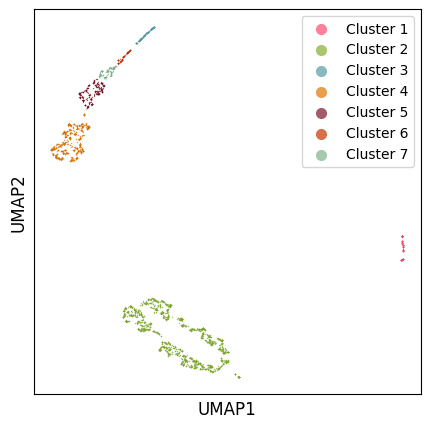

In [54]:
umap_df = pd.DataFrame(umap_vals, columns=["umap1", "umap2"])
umap_df["class"] = df["class"]
umap_df["age"] = df["age"]
umap_df["id"] = df["id"]
umap_df["picnic_score"] = df["picnic_score"]
umap_df["correctly_predicted"] = df["correctly_predicted"]
umap_df["cluster"] = lables
umap_df = umap_df[umap_df["class"] != "random"]

colors = ["#ff4c6e", "#84ae30", "#579ca3", "#e07600", "#7c152a", "#ca3100", "#7fb38b"]

fig, ax = plt.subplots(figsize=(5, 5))

for i in sorted(umap_df.cluster.unique()):

    if i == -1:
        ax.scatter(umap_df[umap_df["cluster"] == i]["umap1"], umap_df[umap_df["cluster"] == i]["umap2"], s=1, alpha=0.7, c="lightgray", edgecolors="black", linewidths=0.01)
    else:
        ax.scatter(umap_df[umap_df["cluster"] == i]["umap1"], umap_df[umap_df["cluster"] == i]["umap2"], s=1, alpha=0.7, c=colors[i], edgecolors="black", linewidths=0.01, label=f"Cluster {i + 1}")


ax.legend(markerscale=8, fontsize=10)

ax.set_xticks([])
ax.set_yticks([])

ax.set_xlabel("UMAP1", fontsize=12)
ax.set_ylabel("UMAP2", fontsize=12)

#plt.savefig("LLPS_clusters.pdf", dpi=300)

/var/folders/9x/smcwc3jj20b87jkkkrgmlz7c0000gn/T/ipykernel_38659/368913554.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0,1,2,3,4,5,6,7])


Text(0, 0.5, 'Realtiv Cluster Composition')

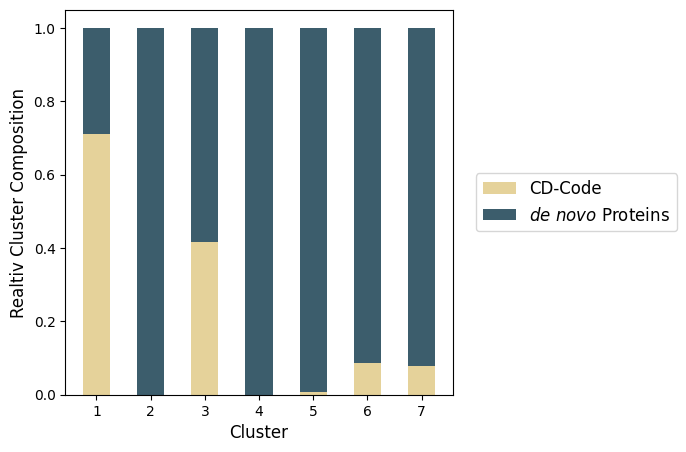

In [55]:
# Stacked bar grpah to show the fraction of protein classes in each cluster
cluster_counts = umap_df.groupby(["cluster", "class"]).size().reset_index(name="counts")



#calculate fraction of each class in each cluster
cluster_counts["fraction"] = np.nan

for cluster in cluster_counts["cluster"].unique():
    
    if len(cluster_counts[cluster_counts["cluster"] == cluster]) == 1:
        if cluster_counts[cluster_counts["cluster"] == cluster]["class"].values[0] == "cd_code":
            cluster_counts.loc[len(cluster_counts)] = [cluster, "denovo", 0, 0]
        else:
            cluster_counts.loc[len(cluster_counts)] = [cluster, "cd_code", 0, 0]
    
    try:
            cd_code_count = cluster_counts[(cluster_counts["cluster"] == cluster) & (cluster_counts["class"] == "cd_code")]["counts"].values[0]
            denovo_count = cluster_counts[(cluster_counts["cluster"] == cluster) & (cluster_counts["class"] == "denovo")]["counts"].values[0]

            fraction_cd_code = cd_code_count / (cd_code_count + denovo_count)
            fraction_denovo = denovo_count / (cd_code_count + denovo_count)

            cluster_counts.loc[(cluster_counts["cluster"] == cluster) & (cluster_counts["class"] == "cd_code"), "fraction"] = fraction_cd_code
            cluster_counts.loc[(cluster_counts["cluster"] == cluster) & (cluster_counts["class"] == "denovo"), "fraction"] = fraction_denovo
    except:
        cluster_counts.loc[(cluster_counts["cluster"] == cluster) & (cluster_counts["class"] == "denovo"), "fraction"] = 1


cluster_counts = cluster_counts.sort_values(by="cluster")
cluster_counts = cluster_counts[cluster_counts["cluster"] != -1] #remove noise cluster

#plot stacked bar graph
fig, ax = plt.subplots(figsize=(5, 5))

ax.bar(range(len(cluster_counts.cluster.unique())), cluster_counts[cluster_counts["class"] == "cd_code"]["fraction"].values, color="#e5d29aff", width=0.5, label="CD-Code")
ax.bar(range(len(cluster_counts.cluster.unique())), cluster_counts[cluster_counts["class"] == "denovo"]["fraction"].values, bottom=cluster_counts[cluster_counts["class"] == "cd_code"]["fraction"].values, color="#3c5d6c", width=0.5, label=r"$\it{de}$ $\it{novo}$ Proteins")
#ax.bar(range(len(cluster_counts.cluster.unique())), cluster_counts[cluster_counts["class"] == "denovo"]["fraction"].values, bottom=cluster_counts[cluster_counts["class"] == "cd_code"]["fraction"].values, color="#43978D", width=0.5, label=r"$\it{de}$ $\it{novo}$ Proteins")
ax.set_xticklabels([0,1,2,3,4,5,6,7])
ax.legend(fontsize=12, loc="right", bbox_to_anchor=(1.6, 0.5))

ax.set_xlabel("Cluster", fontsize=12)
ax.set_ylabel("Realtiv Cluster Composition", fontsize=12)

#plt.savefig("LLPS_cluster_composition.pdf", dpi=300, bbox_inches="tight")

In [56]:
cluster_counts[cluster_counts["class"] == "cd_code"]

,cluster,class,counts,fraction
1,0,cd_code,84,0.711864
14,1,cd_code,0,0.000000
4,2,cd_code,49,0.415254
15,3,cd_code,0,0.000000
7,4,cd_code,2,0.008368
9,5,cd_code,7,0.087500
11,6,cd_code,8,0.078431


In [57]:
cd

,REP_Q2,REP_N2,REP_S2,REP_G2,REP_E2,REP_D2,REP_K2,REP_R2,REP_P2,REP_QN2,...,SCD,kappa*,omega*,aromatic_spacing*,omega_aromatic*,id,picnic_score,sequence,seqLen,correctly_predicted
0,0.0,1.0,2.0,0.0,3.0,1.0,4.0,1.0,0.0,1.0,...,-1.058014,0.718464,-0.255042,0.527774,0.527774,P45973,0.834747,MGKKTKRTADSSSSEDEEEYVVEKVLDRRVVKGQVEYLLKWKGFSE...,191,True
1,0.0,0.0,3.0,1.0,3.0,2.0,0.0,1.0,4.0,0.0,...,7.877785,2.038676,0.299853,-0.182470,-0.182470,O43561,0.383217,MEEAILVPCVLGLLLLPILAMLMALCVHCHRLPGSYDSTSSDSLYP...,262,False
2,2.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,4.0,...,-0.342546,-1.094951,0.271488,-0.685668,-0.685668,P62993,0.814886,MEAIAKYDFKATADDELSFKRGDILKVLNEECDQNWYKAELNGKDG...,217,True
3,0.0,0.0,2.0,3.0,6.0,8.0,3.0,0.0,1.0,3.0,...,2.135743,2.771443,-0.655650,1.635371,1.635371,P06748,0.866906,MEDSMDMDMSPLRPQNYLFGCELKADKDYHFKVDNDENEHQLSLRT...,294,True
4,0.0,2.0,6.0,28.0,2.0,1.0,2.0,1.0,0.0,5.0,...,-0.117335,0.767764,-0.078294,-2.366663,-2.366663,P09651,0.916104,MSKSESPKEPEQLRKLFIGGLSFETTDESLRSHFEQWGTLTDCVVM...,372,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,2.0,0.0,5.0,4.0,14.0,7.0,6.0,4.0,9.0,4.0,...,-1.283617,3.271241,-1.388692,0.437204,0.437204,O94953,0.666521,MGSEDHGAQNPSCKIMTFRPTMEEFKDFNKYVAYIESQGAHRAGLA...,1096,True
172,11.0,0.0,3.0,1.0,13.0,2.0,1.0,3.0,1.0,21.0,...,16.333701,2.178228,0.481817,1.239445,1.239445,P26339,0.771292,MRSTAVLALLLCAGQVFALPVNSPMTKGDTKVMKCVLEVISDSLSK...,463,True
173,14.0,1.0,5.0,1.0,15.0,2.0,2.0,3.0,1.0,27.0,...,14.724740,1.897871,0.608575,1.659638,1.659638,P10354,0.809237,MRSSAALALLLCAGQVFALPVNSPMTKGDTKVMKCVLEVISDSLSK...,466,True
174,2.0,1.0,4.0,1.0,19.0,0.0,2.0,3.0,1.0,6.0,...,22.710372,1.183271,0.271811,0.205935,0.205935,P10645,0.781725,MRSAAVLALLLCAGQVTALPVNSPMNKGDTEVMKCIVEVISDTLSK...,457,True


In [58]:
#Assign age group for de novo proteins
def assign_Age_group(x):
    if x < 5:
        return 1
    elif x < 30:
        return 2
    else:
        return 3

umap_df["age_group"] = umap_df["age"].apply(lambda x: assign_Age_group(x))

In [59]:
umap_df["age_group"].value_counts()

1    2202
3     345
2     110
Name: age_group, dtype: int64

In [60]:
high_confidence_denovos = umap_df[
    ((umap_df["cluster"] == 0) | (umap_df["cluster"] == 2)) &
    (umap_df["class"] == "denovo") &
    (umap_df["picnic_score"] >= 0.5)
]

In [61]:
high_confidence_denovos

,umap1,umap2,class,age,id,picnic_score,correctly_predicted,cluster,age_group
0,-41.353455,26.762470,denovo,37.184580,droso_1,0.853150,Unkown,2,3
70,-42.507164,25.347498,denovo,3.370336,droso_1105,0.814179,Unkown,2,1
120,-12.780085,-4.248964,denovo,3.370336,droso_1187,0.698769,Unkown,0,1
143,-41.671803,26.390316,denovo,37.184580,droso_1228,0.533979,Unkown,2,3
179,-12.631370,-5.878572,denovo,37.184580,droso_1292,0.531836,Unkown,0,3
...,...,...,...,...,...,...,...,...,...
2391,-12.720608,-5.288763,denovo,0.000000,droso_6639,0.737075,Unkown,0,1
2400,-42.973610,24.760462,denovo,31.053203,droso_6680,0.544691,Unkown,2,3
2445,-42.151192,25.802912,denovo,0.000000,droso_824,0.760135,Unkown,2,1
2459,-43.005119,24.720816,denovo,0.000000,droso_883,0.628057,Unkown,2,1


(-1.110720377744469,
 1.1108212364939987,
 -1.1105981649238095,
 1.102835846072639)

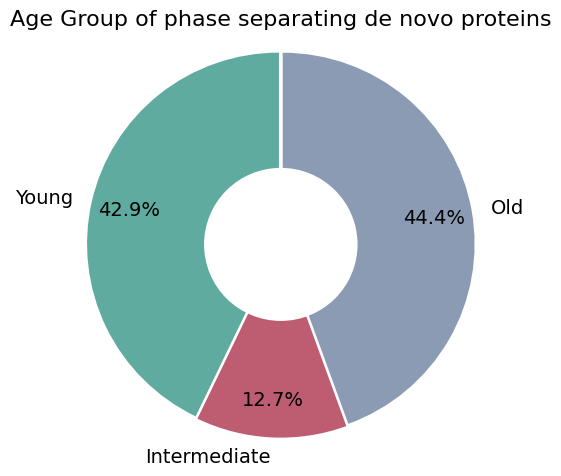

In [62]:
fig, ax = plt.subplots(figsize=(5.5, 5.5))

colors = ["#60aba0", "#be5c71", "#8b9bb4"]
labels = ["Young", "Intermediate", "Old"]
explode = (0.01, 0.01, 0.01)

sizes = high_confidence_denovos.groupby("age_group")["id"].nunique().values
ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.8, textprops={'fontsize': 14})
ax.set_title("Age Group of phase separating de novo proteins", fontsize=16)
centre_circle = plt.Circle((0,0),0.40,fc='white')
ax.add_artist(centre_circle)
ax.axis('equal')

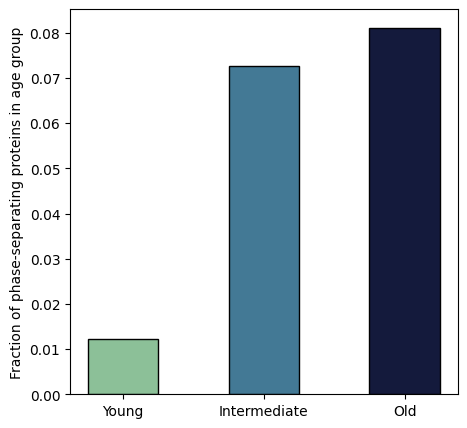

In [90]:
# bar plot to show the fraction per age group of all high confidence de novo proteins
fig, ax = plt.subplots(figsize=(5, 5))

colors = ["#8cc098", "#437995", "#141a3c"]
labels = ["Young", "Intermediate", "Old"]

sizes = [
    len(high_confidence_denovos[high_confidence_denovos["age_group"] == 1]) / len(umap_df[umap_df["age_group"] == 1]),
    len(high_confidence_denovos[high_confidence_denovos["age_group"] == 2]) / len(umap_df[umap_df["age_group"] == 2]),
    len(high_confidence_denovos[high_confidence_denovos["age_group"] == 3]) / len(umap_df[umap_df["age_group"] == 3])
]

ax.bar(labels, sizes, color=colors, width=0.5, edgecolor="black", linewidth=1)
ax.set_ylabel("Fraction of phase-separating proteins in age group", fontsize=10);

plt.savefig("LLPS_age_group.pdf", dpi=300, bbox_inches="tight")



In [87]:
#Chi square test to test if the fraction of phase separating proteins in each age group is significantly different from the expected fraction
from scipy.stats import chisquare

f_exp = (umap_df[umap_df["class"] == "denovo"]["age_group"].value_counts().values / len(umap_df[umap_df["class"] == "denovo"])) * len(high_confidence_denovos)
f_obs = high_confidence_denovos["age_group"].value_counts().sort_index().values

chisquare(f_obs, f_exp).pvalue

2.4896888304502952e-54

In [88]:
f_exp

array([55.33546071,  4.90027922,  2.76426007])

In [79]:
umap_df["age_group"].value_counts()

1    2202
3     345
2     110
Name: age_group, dtype: int64

In [72]:
umap_df[umap_df["class"] == "denovo"]["age_group"].value_counts().sum()

2507

In [81]:
high_confidence_denovos["age_group"].value_counts().sort_index().values

array([27,  8, 28])

In [85]:
f_obs

array([27,  8, 28])